# Comparing measures from >2 groups (unrelated subjects)

We will explore how we can compare measures from >2 groups of unrelated subjects

![test_3_sample_independent.png](images/test_3_sample_independent.png)

---
## Data preparation

We will be using a dataset from https://vincentarelbundock.github.io/Rdatasets/csv/MASS/anorexia.csv

The dataset contains the pre and post weights (in pounds) of anorexic patients in 3 different treatment groups
- `Cont`: control
- `CBT`: cognitive behavioural therapy
- `FT`: family therapy

We will pre-process the dataset
- Create a new `Weight` variable calculated from the difference of weights pre and post treatment
- Relevel the `Treat` variable to order the treatments as `Cont`, `CBT`, `FT`

In [1]:
library(tidyverse)

data <- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/anorexia.csv")

data <- data %>% 
        mutate(Weight = Postwt - Prewt,
               Treat = as.factor(Treat)) %>%
        mutate(Treat = fct_relevel(Treat, "Cont","CBT","FT")) %>%
        select(Treat, Weight)

head(data %>% filter(Treat=="Cont"))
head(data %>% filter(Treat=="CBT"))
head(data %>% filter(Treat=="FT"))


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

New names:
* `` -> ...1

Rows: 72 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Treat
dbl (3): ...1, Prewt, Postwt

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Treat,Weight
<fct>,<dbl>
Cont,-0.5
Cont,-9.3
Cont,-5.4
Cont,12.3
Cont,-2.0
Cont,-10.2


Treat,Weight
<fct>,<dbl>
CBT,1.7
CBT,0.7
CBT,-0.1
CBT,-0.7
CBT,-3.5
CBT,14.9


Treat,Weight
<fct>,<dbl>
FT,11.4
FT,11.0
FT,5.5
FT,9.4
FT,13.6
FT,-2.9


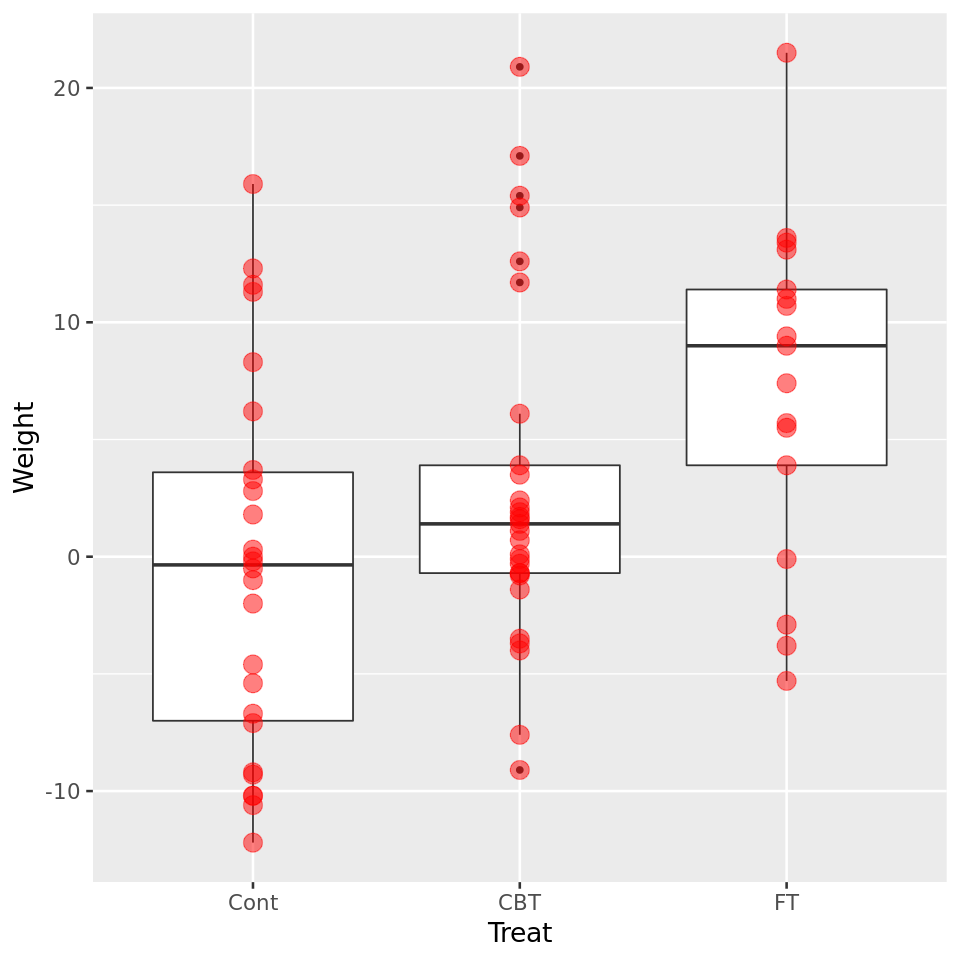

In [2]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data %>% 
ggplot(aes(x=Treat, y=Weight)) + 
  geom_boxplot() +
  geom_point(color = "red", size=5, alpha=0.5) +
  theme_grey(base_size=16)

Visually we can see that there might be a difference among the treatment groups for the anorexic patients but we are not sure if the difference is likely to occur by chance

---
## How to quantify these differences among groups?

We can quantify differences among groups by considering
- The variance between groups $\mathit{Var}_\mathit{between}$
- The total variance within groups $\mathit{Var}_\mathit{within}$

![anova_f_ratio_small.png](images/anova_f_ratio_small.png)

We can calculate the ratio between the two variances $\mathit{Var}_\mathit{between}/\mathit{Var}_\mathit{within}$ to compare the variance observed between the groups to the total variance within the groups
- A higher ratio would suggest an overall difference among the groups

![anova_f_ratio_large.png](images/anova_f_ratio_large.png)

This ratio is known as the F-statistic (after Fisher)

$$
\begin{align}
F_\mathit{independent} &=\frac{\text{Variance between groups}}{\text{Variance within groups}} \\
  &=\frac{SS_\mathit{between}/\mathit{df}_\mathit{groups}}
  {SS_\mathit{within}/\mathit{df}_\mathit{samples}}
\end{align}
$$

$$
\begin{align}
\text{where }\mathit{df}_\mathit{groups} &= n_\mathit{groups}-1, \\
\mathit{df}_\mathit{samples} &= n_\mathit{samples} - n_\mathit{groups}
\end{align}
$$

### 1. Calculate the sum of squared differences between groups

![anova_ss_between.png](images/anova_ss_between.png)

In [3]:
ss_between <- data %>%
              mutate(total_mean = mean(Weight)) %>% # calculate the grand mean
              group_by(Treat) %>%               # calculate per treatment group
                mutate(mean_per_treatment_grp = mean(Weight),   # mean effect per treatment group
                      diff_sq = (mean_per_treatment_grp - total_mean)^2)%>% # squared mean diff (each treatment group to grand mean)
              ungroup %>% # collapse all groups
              summarize(ss = sum(diff_sq)) %>% # sum all squared diff
              pull

ss_between

[1] 614.6437

### 2. Calculate the sum of squared differences within the groups

![anova_ss_within.png](images/anova_ss_within.png)

In [4]:
ss_within <- data %>%
             group_by(Treat) %>% # calculate per treatment group
               mutate(mean_per_treatment_grp = mean(Weight), # mean effect per treatment group
                      diff_sq = (Weight - mean_per_treatment_grp)^2) %>% # squared mean diff (effects in each treatment group to the mean of the whole treatment group)) 
             ungroup %>%
             summarize(ss = sum(diff_sq)) %>%
             pull

ss_within

[1] 3910.742

We can now calculate the F-statistic

$$
\begin{align}
F_\mathit{independent} &=\frac{\text{Variance between groups}}{\text{Variance within groups}} \\
  &=\frac{SS_\mathit{between}/\mathit{df}_\mathit{groups}}
  {SS_\mathit{within}/\mathit{df}_\mathit{samples}}
\end{align}
$$


$$
\begin{align}
\text{where }\mathit{df}_\mathit{groups} &= n_\mathit{groups}-1, \\
\mathit{df}_\mathit{samples} &= n_\mathit{samples} - n_\mathit{groups}
\end{align}
$$

In [5]:
# get number of categories and number of samples
num_groups <- nlevels(data$Treat)
num_samples <- nrow(data)

# calculate variances
var_between <- ss_between/(num_groups-1)
var_within <- ss_within/(num_samples - num_groups)

# calculate F-ratio
obs_stat_f <- var_between/var_within
obs_stat_f

[1] 5.422297

**Using a function**

We can also calculate the F-statistic using the `anova_test` function from the `rstatix` library
- `dependent variable` ~ `independent variable` for the weight and treatment groups

In [6]:
data %>% 
rstatix::anova_test(Weight ~ Treat) %>% 
pull(F)

Coefficient covariances computed by hccm()



[1] 5.422

---
## 1. Resampling approach

To get an intuition of the null hypothesis test, we can use the resampling approach
- To do this, we randomly mix the  values among the 3 groups and do this multiple times to generate a _dataset that represents the null hypothesis_
- We then calculate the F-statistic for each of the permutations to generate the null distribution of values
- Finally, we calculate the _p-value_, which is the probability we find an F-statistic value in the null distribution that is equal/greater than what we observe in the data

$$P(\text{Data}|\text{Null distribution})$$

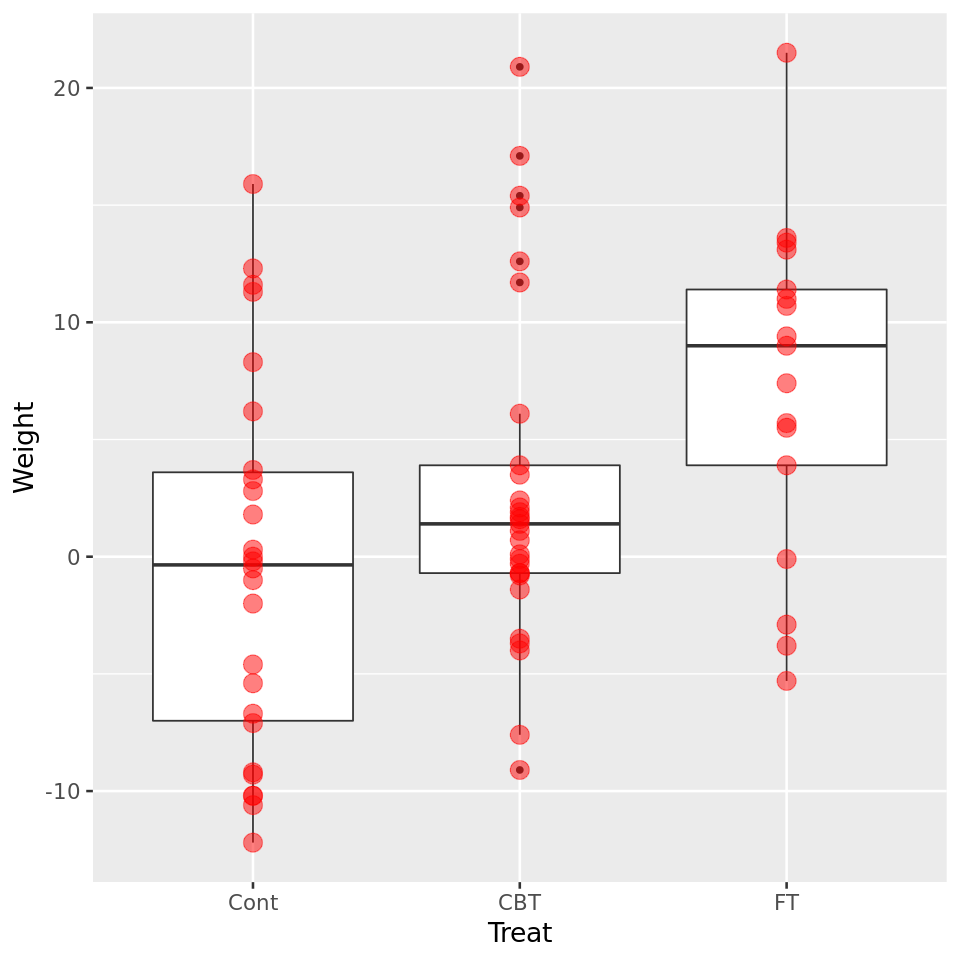

In [7]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data %>% 
ggplot(aes(x=Treat, y=Weight)) + 
  geom_boxplot() +
  geom_point(color = "red", size=5, alpha=0.5) +
  theme_grey(base_size=16)

### 1.1. Calculate the test statistic

We calculate the standardized F-score that quantifies the differences among the groups for independent subjects, using the `anova_test` function from the `rstatix` library

In [8]:
obs_stat_f <- data %>% 
              rstatix::anova_test(Weight ~ Treat) %>% 
              pull(F)

obs_stat_f

Coefficient covariances computed by hccm()



[1] 5.422

### 1.2. Generate a null distribution by resampling

First, we will generate 1000 samples from the data by randomly permuting the different groups

In [9]:
library(infer)

num_resample <- 1000

permute <- data %>%
           specify(Weight ~ Treat) %>%
           hypothesize(null="independence") %>%
           generate(reps=num_resample, type="permute")

# taking a look
head(permute)
tail(permute)

Weight,Treat,replicate
<dbl>,<fct>,<int>
1.8,Cont,1
-0.1,Cont,1
15.9,Cont,1
-5.3,Cont,1
15.4,Cont,1
1.1,Cont,1


Weight,Treat,replicate
<dbl>,<fct>,<int>
6.1,FT,1000
-0.3,FT,1000
0.3,FT,1000
-6.7,FT,1000
-12.2,FT,1000
11.4,FT,1000


We can plot a sample of the randomly permuted dataset

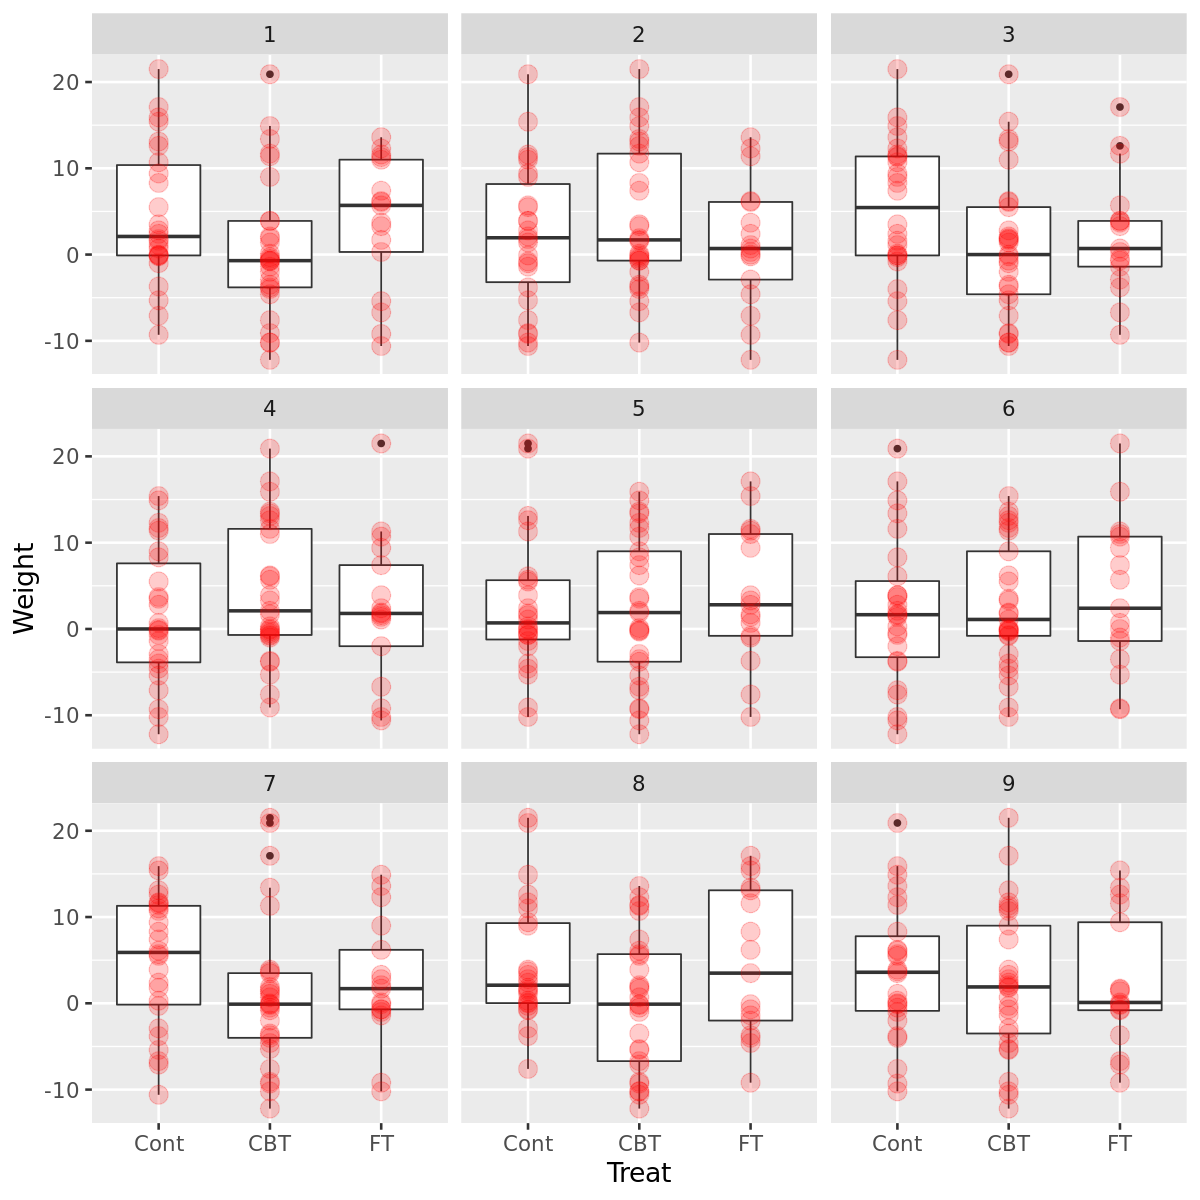

In [10]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=10)

permute %>% 
filter(replicate <= 9) %>%        # select first 9 replicates
ggplot(aes(x = Treat, y = Weight)) +   # do boxplots
  geom_boxplot() +
  geom_point(color="red", size=5, alpha=0.2) +
  facet_wrap(~replicate) + 
  theme_grey(base_size=16)

We calculate the F-statistic for each replicate by using the `anova_test` function from the `rstatix` library

In [11]:
resample <- permute %>%
            group_by(replicate) %>%
            {suppressMessages(rstatix::anova_test(data = ., Weight ~ Treat))} %>%
            as_tibble %>%
            rename(stat=F) %>%
            select(replicate, stat)

head(resample)
tail(resample)

replicate,stat
<int>,<dbl>
1,1.722
2,0.815
3,2.124
4,0.969
5,0.247
6,0.252


replicate,stat
<int>,<dbl>
995,1.331
996,1.456
997,0.195
998,0.516
999,0.237
1000,0.429


We now have a distribution of F-statistics under the assumption that there were no differences among the groups

### 1.3. Use the null distribution to calculate the p-value

Now that we have the F-statistic null distribution, we can check if any of these values exceed the observed F-statistic in the data ```obs_stat_f```

In [12]:
resample <- resample %>% 
            mutate(exceed = if_else(abs(stat) >= abs(obs_stat_f), "Y","N") %>%
                            factor(levels=c("Y","N")))

head(resample)
tail(resample)

replicate,stat,exceed
<int>,<dbl>,<fct>
1,1.722,N
2,0.815,N
3,2.124,N
4,0.969,N
5,0.247,N
6,0.252,N


replicate,stat,exceed
<int>,<dbl>,<fct>
995,1.331,N
996,1.456,N
997,0.195,N
998,0.516,N
999,0.237,N
1000,0.429,N


We can visualize the distribution of F-statistic values and indicate those values that are equal or exceed  the observed F-statistic in the data

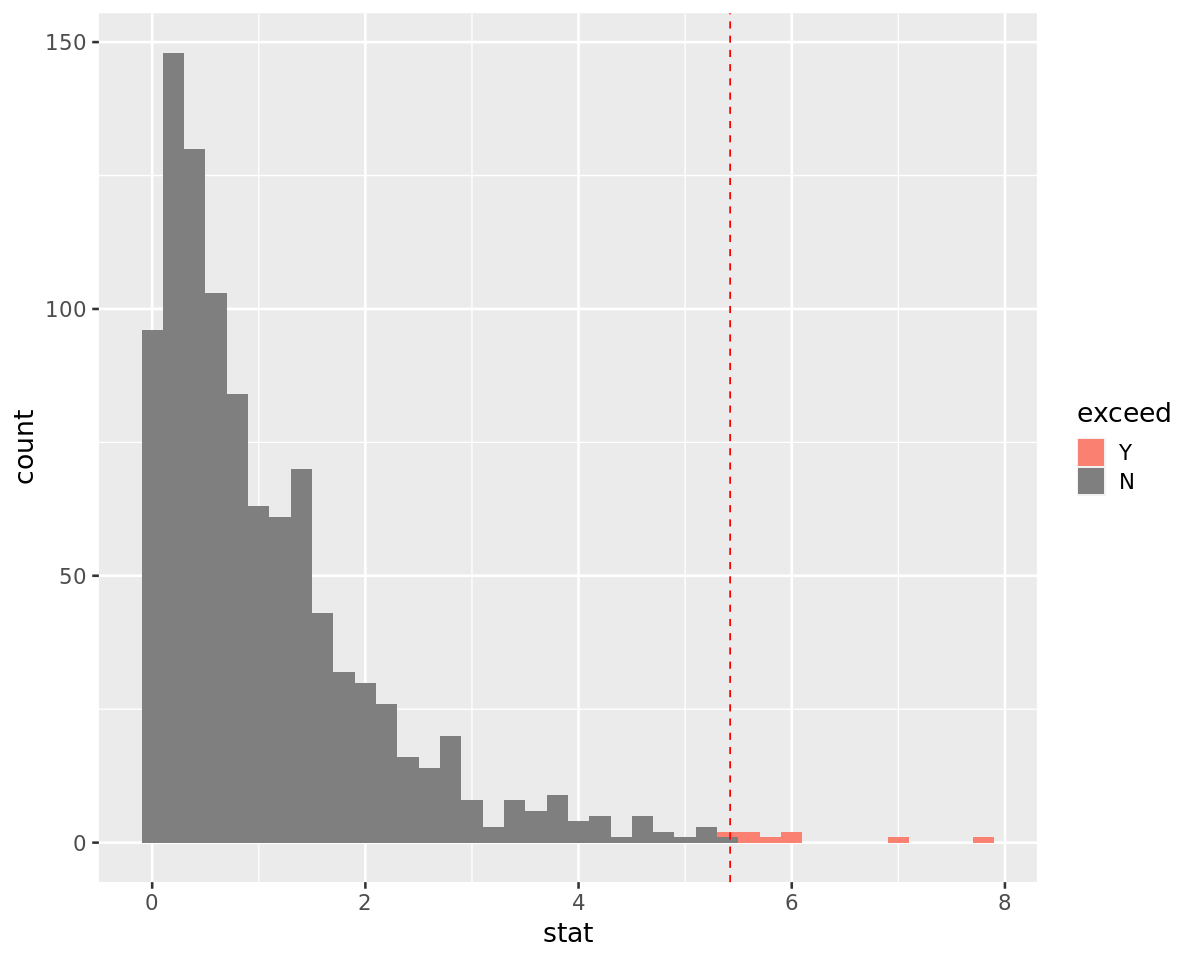

In [13]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=8)

resample %>% 
ggplot(aes(x=stat, fill=exceed)) + 
  geom_histogram(binwidth=0.2) + 
  geom_vline(xintercept = obs_stat_f, color = "red", linetype="dashed") +
  scale_fill_manual(values=c("salmon", "grey50"), 
                    labels=c("Y","N"), drop=FALSE) +
  theme(legend.position = "top") +
  theme_grey(base_size=16)

Finally, we can get the _p-value_ by calculating how many times the F-statistic in the null distribution equals or exceeds what we observe in the data

In [14]:
resample %>% 
summarize(num_resample = n(),
          num_exceed = if_else(exceed == "Y", 1,0) %>% sum,
          p_value = num_exceed/num_resample)

num_resample,num_exceed,p_value
<int>,<dbl>,<dbl>
1000,8,0.008


As the p-value is small, the observed difference is less likely to be due to random chance

---
## 2. Analytical approach (1-way ANOVA)

In the analytical approach, the null distribution is not derived from resampling, but it is calculated from a theoretical formula that generalizes the distribution

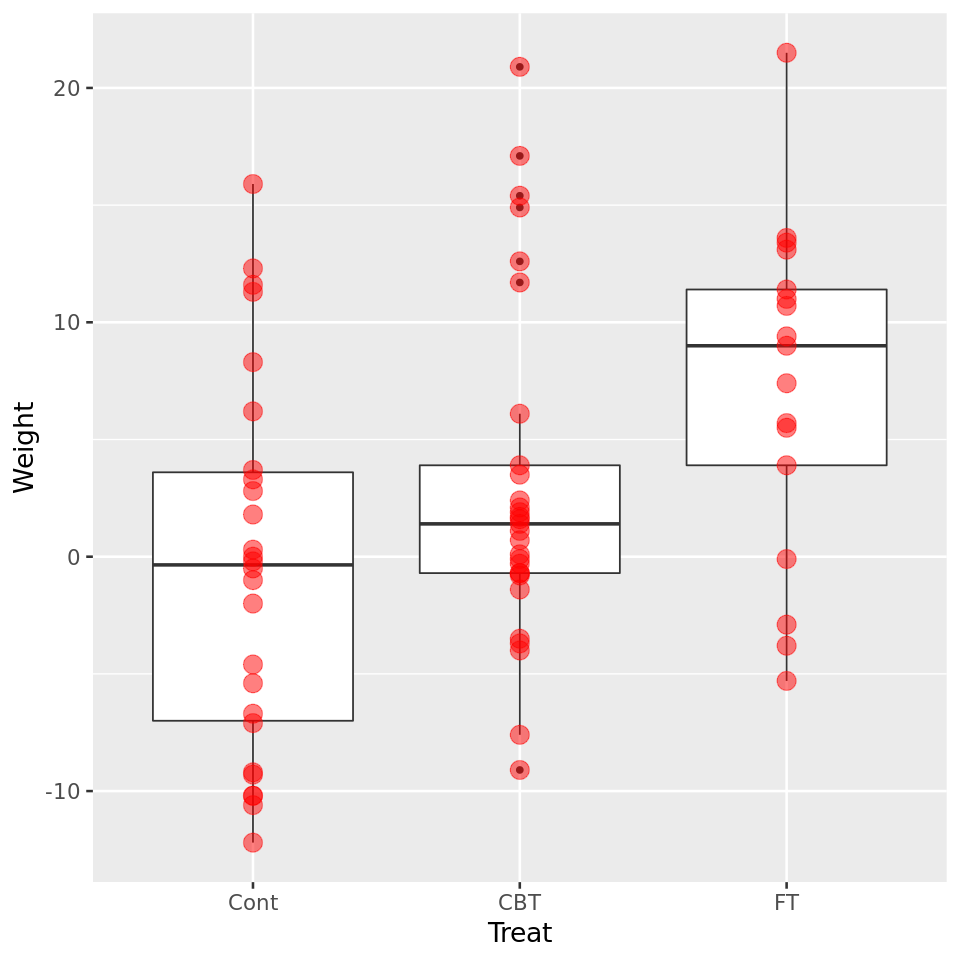

In [15]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data %>% 
ggplot(aes(x=Treat, y=Weight)) + 
  geom_boxplot() +
  geom_point(color = "red", size=5, alpha=0.5) +
  theme_grey(base_size=16)

### 2.1. Calculate the test statistic

We calculate the standardized F-score that quantifies the differences among the groups for independent subjects, using the `anova_test` function from the `rstatix` library

In [16]:
obs_stat_f <- data %>% 
              rstatix::anova_test(Weight ~ Treat) %>% 
              pull(F)

obs_stat_f

Coefficient covariances computed by hccm()



[1] 5.422

### 2.2. Use the theoretical null distribution to calculate the p-value

The null F-distribution is parameterized by the [degrees of freedom](http://www.rondotsch.nl/degrees-of-freedom/)  between groups (`df1`) and within groups (`df2`).

- `df1` = number of groups - 1
- `df2` = number of samples - number of groups

$$
\begin{align}
F &\sim\frac{\text{Distribution variance between groups}}{\text{Distribution variance within groups}} \\
  &\sim\frac{\chi^{2}(\mathit{df}_{1})}{\mathit{df}_{1}}/\frac{\chi^{2}(\mathit{df}_{2})}{\mathit{df}_{2}}
\end{align}
$$

In [17]:
# get number of categories and number of samples
num_categories <- nlevels(data$Treat)
num_samples <- nrow(data)

# calculate degrees of freedom (within group)
df_within_group <- num_samples - num_categories

# calculate degrees of freedom (between group)
df_between_groups <- num_categories - 1

tibble(df_between_groups=df_between_groups,
       df_within_group=df_within_group)

df_between_groups,df_within_group
<dbl>,<int>
2,69


We use the `vdist_f_prob` function from `vistributions` library to plot the F-distribution and calculate the p-value
- `perc` = observed F-statistic from data
- `num_df` = degrees of freedom between groups
- `den_df` = degrees of freedom within groups

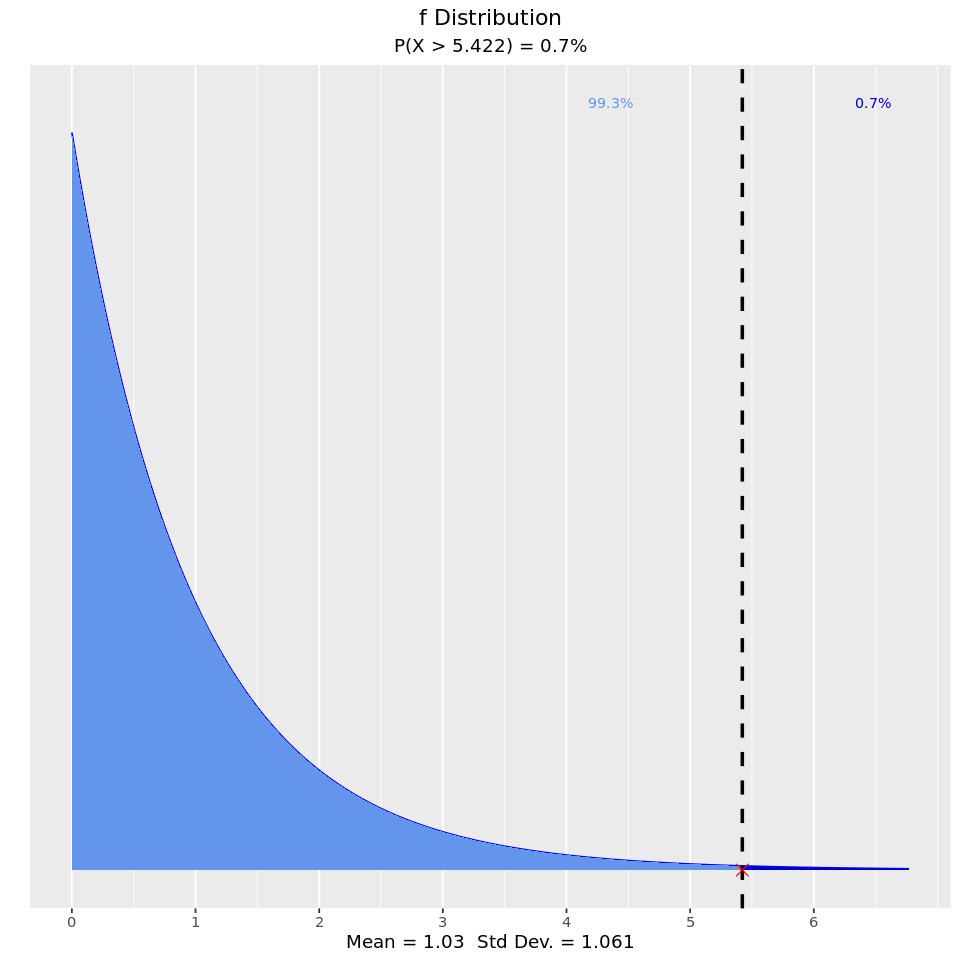

In [18]:
library(vistributions)

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

vdist_f_prob(perc = obs_stat_f, 
             num_df = df_between_groups, 
             den_df = df_within_group, 
             type="upper")

We find that the p-value is ~0.007 (or 0.7%), which is close to the what we got with the resampling approach

**Using a function**

We can also get the same result by using the `anova_test` function from `rstatix` library
- `dependent variable` ~ `independent variable` for weight outcome and treatment groups
- `detailed = TRUE`

In [19]:
data %>% 
rstatix::anova_test(Weight ~ Treat, 
                    detailed = T)

Coefficient covariances computed by hccm()



,Effect,SSn,SSd,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Treat,614.644,3910.742,2,69,5.422,0.006,*,0.136


The ANOVA test does make an assumption that the variances of the different groups are equal. 

![anova_f_ratio_large.png](images/anova_f_ratio_large.png)

If the data does not have roughly equal variances, an alternative Welch's ANOVA test is available through the `welch_anova_test` function

In [20]:
data %>% 
group_by(Treat) %>%
summarize(var = var(Weight))

Treat,var
<fct>,<dbl>
Cont,63.81940
CBT,53.41424
FT,51.22868


In [21]:
data %>% rstatix::welch_anova_test(Weight ~ Treat)

,.y.,n,statistic,DFn,DFd,p,method
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Weight,72,5.36,2,41.13588,0.009,Welch ANOVA


---
## 3. Rank-based approach (Kruskal-Wallis)

The analytic approach based on theoretical distributions assumes a normal distribution of the data. This parametric approach may not work well under certain situations
- Small and/or skewed data that are not normally distributed
- Data that are ordinal in nature (e.g. pain score, ranking of food preferences)

We will use the same dataset to illustrate the **Kruskal-Wallis test** for independent samples
- Convert values to ranks
- Calculate the test statistic (H)
- Calculate the p-value based on the null distribution

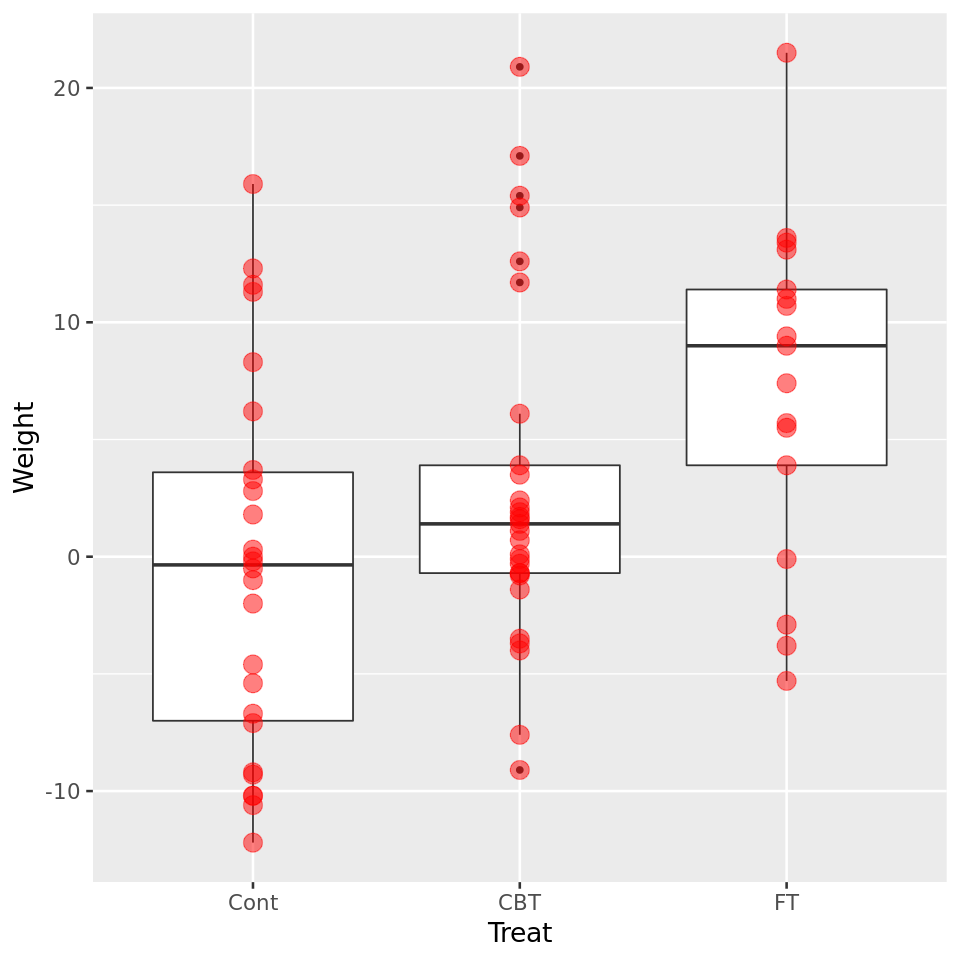

In [22]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data %>% 
ggplot(aes(x=Treat, y=Weight)) + 
  geom_boxplot() +
  geom_point(color = "red", size=5, alpha=0.5) +
  theme_grey(base_size=16)

We can examine the QQ-plot to see if the values deviate from a normal distribution

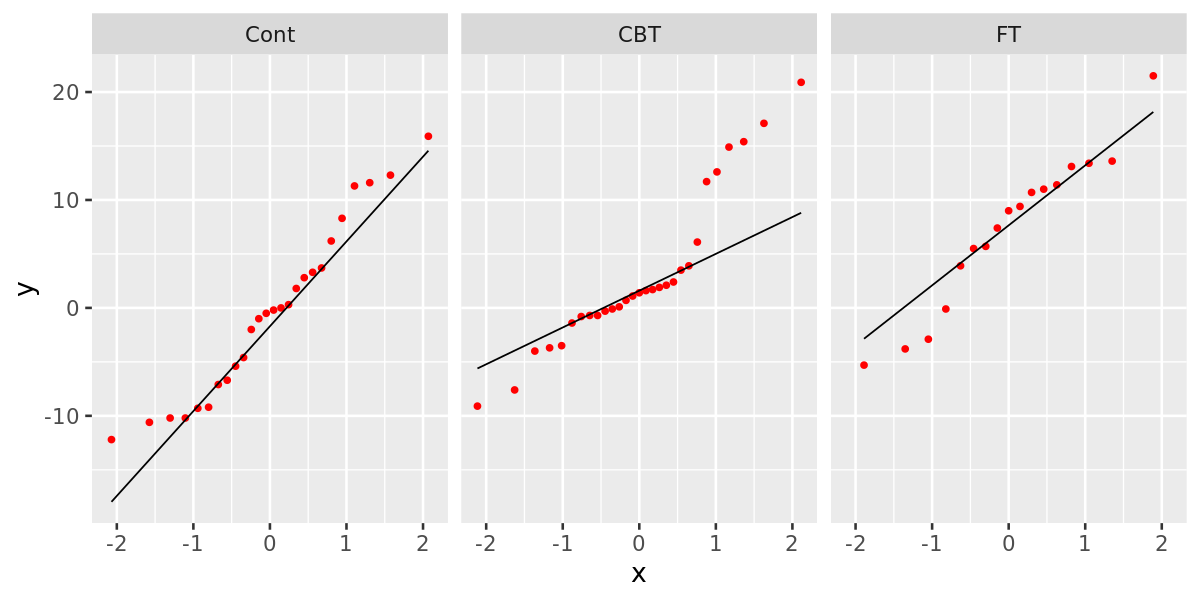

In [23]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=5)

data %>% 
ggplot(aes(sample=Weight)) + 
  geom_qq(color="red") +
  geom_qq_line() +
  facet_grid(.~Treat) +
  theme_grey(base_size = 16)

As some of the measures do not appear to be normally distributed, a rank-based approach can be used

### 3.1. Calculate test statistic

We will calculate the H-statistic
- Convert the values to ranks
- Calculate the sum of squared differences between the mean rank per group and the total mean rank =   $SSR_\text{between}$
- Calculate the sum of squared differences for all ranks and the total mean rank = $SSR_\text{total}$ 
- Calculate the H-statistic 

$$H=\frac{S S R_{\text {between }}}{S S R_{\text {total }} /(N-1)}$$

$$
\text{where } N = \text{total number of samples}
$$

First, we convert the values to ranks

In [24]:
data_rank <- data %>% 
             mutate(rank=rank(Weight))

data_rank %>% sample_n(10)

Treat,Weight,rank
<fct>,<dbl>,<dbl>
Cont,-9.3,5
CBT,1.7,37
Cont,11.6,60
CBT,15.4,68
Cont,2.8,42
Cont,-10.6,2
Cont,-0.2,27
CBT,-0.8,22
Cont,-4.6,13


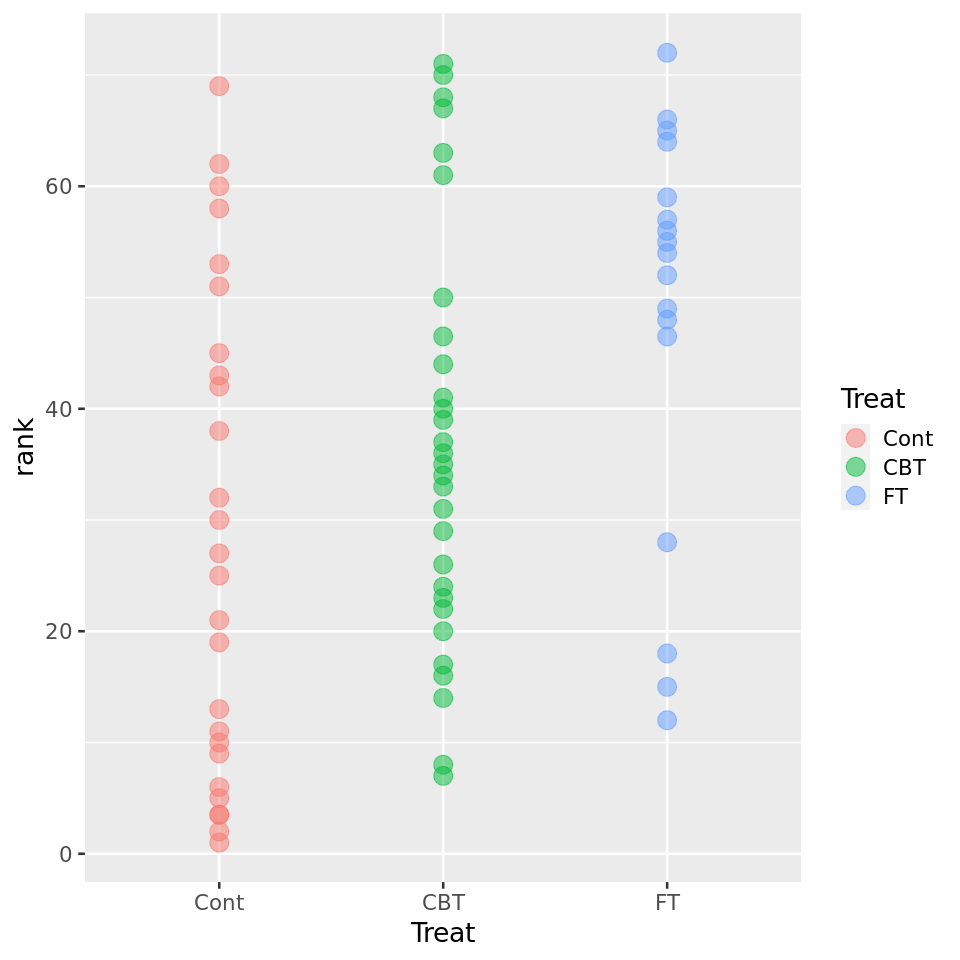

In [25]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data_rank %>% 
ggplot(aes(x=Treat, y=rank, color=Treat)) + 
  geom_point(size=5, alpha=0.5) +
  theme_gray(base_size=16)

Next, we calculate 
- $SSR_\text{between}$ = sum of squares of differences between the mean rank per group and the total mean rank
- $SSR_\text{total}$ = sum of squares of differences between each rank and the total mean rank

In [26]:
ssr_between <- data_rank %>%
               mutate(total_mean = mean(rank)) %>% # calculate the grand mean
               group_by(Treat) %>%               # calculate per treatment group
                 mutate(mean_per_treatment_grp = mean(rank),   # mean effect per treatment group
                        diff_sq = (mean_per_treatment_grp - total_mean)^2)%>% # squared mean diff (each treatment group to grand mean)
                 ungroup %>% # collapse all groups
               summarize(ss = sum(diff_sq)) %>% # sum all squared diff
               pull

ssr_total <- data_rank %>%
             mutate(total_mean = mean(rank)) %>% # calculate the grand mean
             mutate(diff_sq = (rank - total_mean)^2)%>% # squared mean diff (each treatment group to grand mean)
             summarize(ss = sum(diff_sq)) %>% # sum all squared diff
             pull

tibble(ssr_between = ssr_between,
       ssr_total = ssr_total)

ssr_between,ssr_total
<dbl>,<dbl>
3962.677,31097


We then calculate the H-statistic

$$H=\frac{S S R_{\text {between }}}{S S R_{\text {total }} /(N-1)}$$

In [27]:
obs_stat_h <- ssr_between/(ssr_total/(nrow(data_rank)-1))
obs_stat_h

[1] 9.047499

**Using a function**

We can obtain the same result using the `kruskal_test` function from the `rstatix` library
- `dependent variable` ~ `independent variable` for weight outcome and treatment groups

In [28]:
data %>% rstatix::kruskal_test(Weight ~ Treat) %>% 
         pull(statistic)

Kruskal-Wallis chi-squared 
                  9.047499

### 3.3. Use the null distribution of ranks to find the p-value

Now that we have the test statistic, we will need to generate a null distribution to compare it to.

#### Using a resampling approach

To get an intuition of the null distribution of H-statistic, we can simulate the null distribution by permuting the different ranks in the groups and calculating the H-statistic for each replicate
- Note that we do not need to resample from the data but generate the distribution of ranks from a range consistent with the number of observations

In [29]:
replicates <- 1000
n_group <- 3
n_samples_per_grp <- 24

# function to simulate random ranks for groups
sample_once <- function(group, n) {
    
    total_ranks <- group * n
    df <- data.frame(group=factor(rep(1:group, each=n)),
                     rank=unlist(sample(seq(1,total_ranks), total_ranks)))
    
    return(df)
}

# permute
permute <- replicate(replicates, sample_once(n_group,n_samples_per_grp), simplify = F) %>% 
           bind_rows %>%
           mutate(replicate=rep(1:replicates, each=n_group * n_samples_per_grp))

# taking a look
head(permute)
tail(permute)

,group,rank,replicate
,<fct>,<int>,<int>
1,1,63,1
2,1,38,1
3,1,2,1
4,1,15,1
5,1,51,1
6,1,52,1


,group,rank,replicate
,<fct>,<int>,<int>
71995,3,11,1000
71996,3,42,1000
71997,3,58,1000
71998,3,16,1000
71999,3,30,1000
72000,3,65,1000


We calculate the H-statistic for each replicate to generate the null distribution and check which values in the null distribution equal or exceed the observed H-statistic

In [30]:
# function to calculate H
h_stat <- function(input) {
    
  ss_rank_between <- input %>%
                     mutate(total_mean = mean(rank)) %>% # calculate the grand mean
                     group_by(group) %>%               # calculate per treatment group
                       mutate(mean_per_treatment_grp = mean(rank),   # mean effect per treatment group
                       diff_sq = (mean_per_treatment_grp - total_mean)^2)%>% # squared mean diff (each treatment group to grand mean)
                     ungroup %>% # collapse all groups
                     summarize(ss = sum(diff_sq)) %>% # sum all squared diff
                     pull
    
  ss_rank_total <- input %>%
                   mutate(total_mean = mean(rank)) %>% # calculate the grand mean
                   mutate(diff_sq = (rank - total_mean)^2)%>% # squared mean diff (each treatment group to grand mean)
                   summarize(ss = sum(diff_sq)) %>% # sum all squared diff
                   pull
    
  return(ss_rank_between/(ss_rank_total/(nrow(input)-1))) # H-statistic
  }
                                 
# function to calculate H for replicates
resample_h <- function(permute_input) {
    
    h <- vector()
    
    for(i in 1:length(unique(permute_input$replicate))) { 
        h <- c(h_stat(permute_input[permute_input$replicate==i,]),h)    
        }
    
    return(tibble(replicate=1:length(unique(permute_input$replicate)),
                  h=h))
    }

In [31]:
resample <- resample_h(permute) %>%
            mutate(exceed=if_else(h >= obs_stat_h, "Y","N") %>% fct_relevel("Y","N"))

head(resample)

replicate,h,exceed
<int>,<dbl>,<fct>
1,0.02111872,N
2,2.78786149,N
3,4.10064688,N
4,0.44882040,N
5,4.37385845,N
6,0.21480213,N


We can plot the null distribution and and see how often the values in the null distribution equal or exceed the observed H-statistic in the data

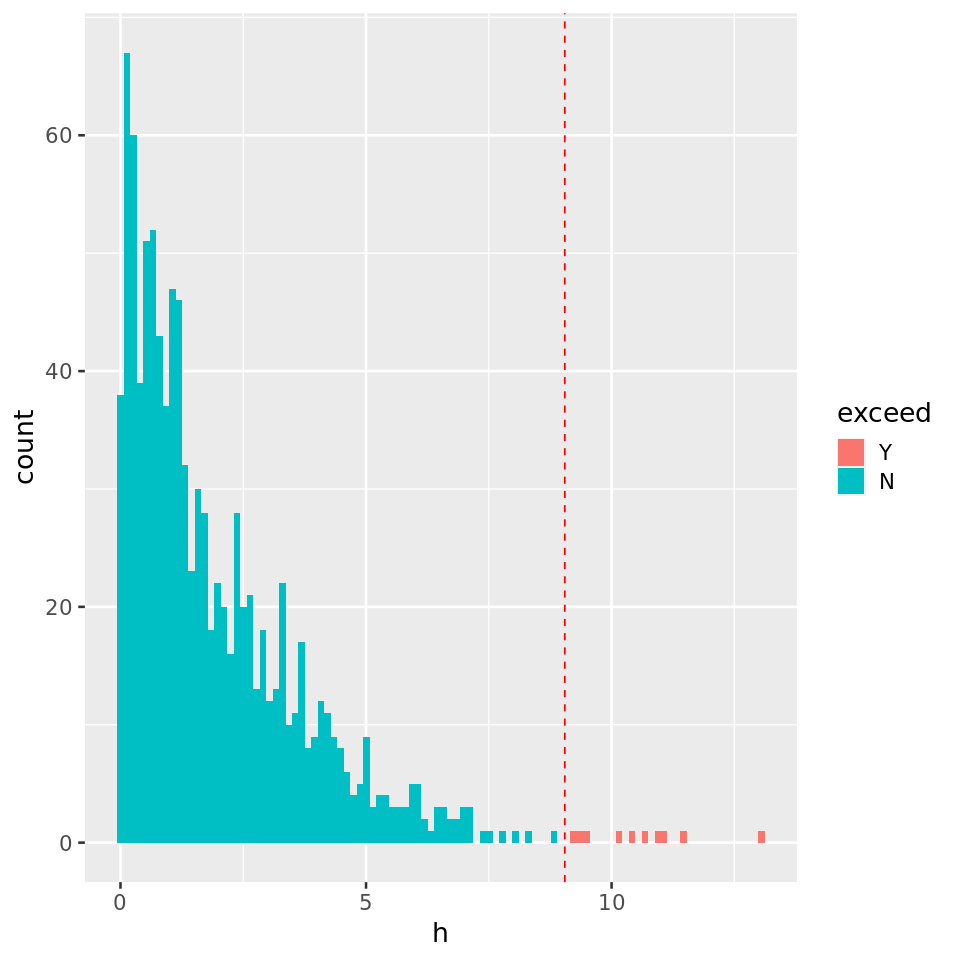

In [32]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

resample %>% 
ggplot(aes(x=h,fill=exceed)) +
  geom_histogram(bins=100) +
  geom_vline(xintercept=obs_stat_h, color="red", linetype="dashed") +
  theme_gray(base_size = 16)

In [33]:
resample %>% 
summarize(num_resample = n(),
          num_exceed = if_else(exceed == "Y", 1,0) %>% sum,
          p_value = num_exceed/num_resample)

num_resample,num_exceed,p_value
<int>,<dbl>,<dbl>
1000,10,0.01


As the p-value is small, the observed differences among the groups are unlikely to be consistent with the null hypothesis that there are no differences. Thus, the observed differences are unlikely to be due to random chance.

#### Using a theoretical null distribution

Analytically, the null distribution approximates a chisquare distribution, with `n-1` degrees of freedom where n = number of groups

We can visualize this using the `vdist_chisquare_prob` function from the `vistributions` library
- `perc` = observed H-statistic
- `df` = number of groups - 1

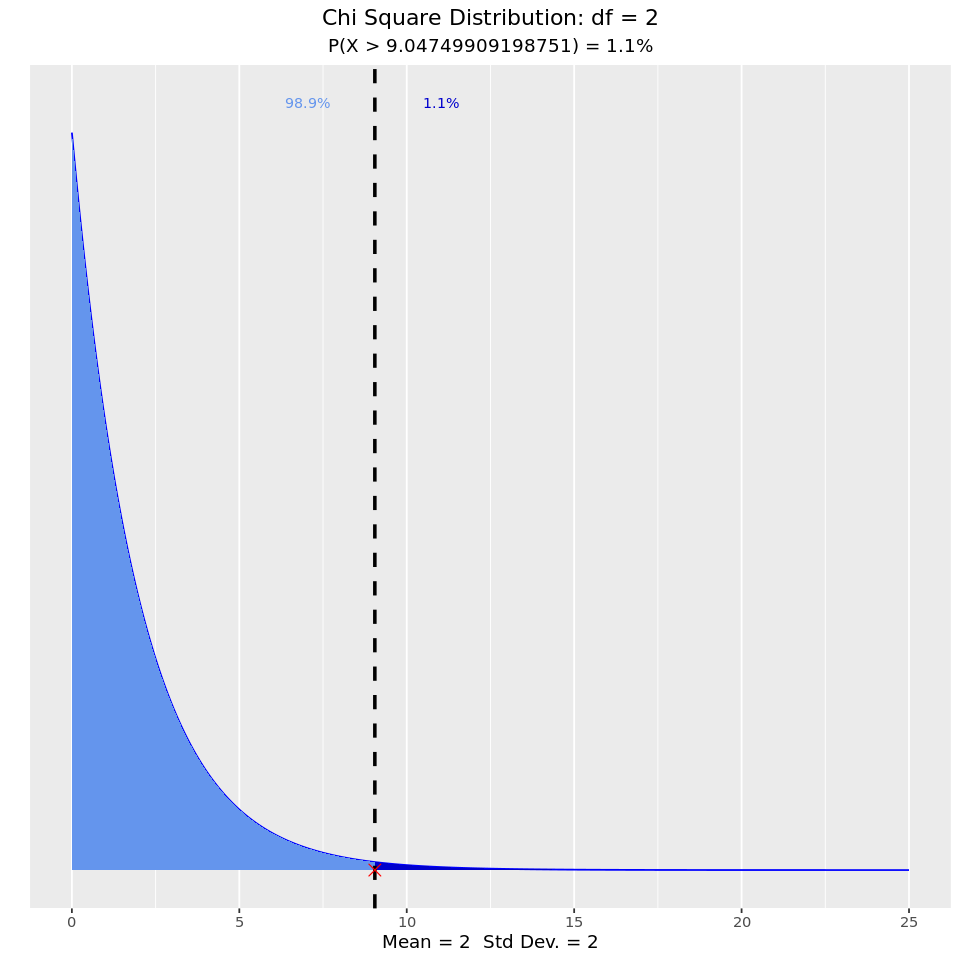

In [34]:
library(vistributions)

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

vdist_chisquare_prob(perc = obs_stat_h, 
                     df=2, 
                     type = "upper")

**Using a function for Kruskal Wallis test**

We can use the `kruskal_test` function from the `rstatix` library
- `dependent variable` ~ `independent variable` for weight outcome and treatment groups

In [35]:
data %>% rstatix::kruskal_test(Weight ~ Treat)

,.y.,n,statistic,df,p,method
,<chr>,<int>,<dbl>,<int>,<dbl>,<chr>
1,Weight,72,9.047499,2,0.0108,Kruskal-Wallis


---
## Effect size

### 1. Parametric

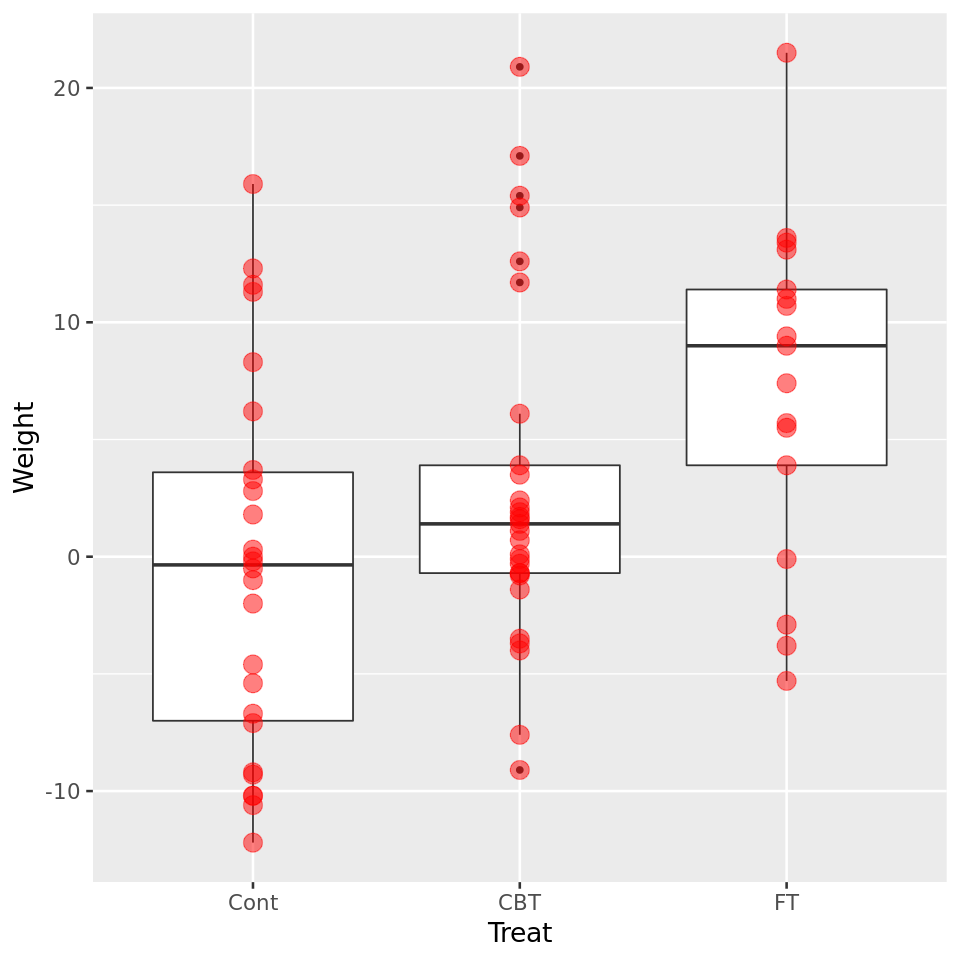

In [36]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data %>% 
ggplot(aes(x=Treat, y=Weight)) + 
  geom_boxplot() +
  geom_point(color = "red", size=5, alpha=0.5) +
  theme_grey(base_size=16)

The effect size for one-way ANOVA is defined by $\eta^2$

$$
\eta^{2}=\frac{S S_{\mathit {Effect }}}{S S_{\mathit {Total }}}
$$

To calculate this, we can first get the sum squared values from the `aov` function to obtain
- $SS_\mathit{effect}$
- $SS_\mathit{error}$

In [37]:
anova_result <- aov(Weight ~ Treat, data)
sum_sq_effect <- summary(anova_result)[[1]][1,"Sum Sq"]
sum_sq_error <- summary(anova_result)[[1]][2,"Sum Sq"]

tibble(sum_sq_effect = sum_sq_effect,
       sum_sq_error = sum_sq_error)

sum_sq_effect,sum_sq_error
<dbl>,<dbl>
614.6437,3910.742


We can calculate the $\eta^2$ effect size

$$
\eta^{2}=\frac{S S_{\mathit {Effect }}}{S S_{\mathit {Total }}}
$$

$$
\text{where } SS_{\mathit{total}}= SS_{\mathit{effect}}+SS_{\mathit{error}}
$$

In [38]:
sum_sq_effect/(sum_sq_effect + sum_sq_error)

[1] 0.1358213

**Using a function**

We can also calculate the eta squared effect size using the `eta_squared` function from the `effectsize` library by passing in the ANOVA result from `aov`

In [39]:
aov(Weight ~ Treat,data) %>% effectsize::eta_squared()

Registered S3 method overwritten by 'parameters':
  method                         from      
  format.parameters_distribution datawizard

For one-way between subjects designs, partial eta squared is equivalent to eta squared.
Returning eta squared.



Parameter,Eta2,CI,CI_low,CI_high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Treat,0.1358213,0.95,0.02485691,1


We can interpret the effect size by passing the value to the `interpret_eta_squared` function from `effectsize` library

In [40]:
aov(Weight ~ Treat,data) %>% 
effectsize::eta_squared() %>%
pull(Eta2) %>%
effectsize::interpret_eta_squared()

For one-way between subjects designs, partial eta squared is equivalent to eta squared.
Returning eta squared.



[1] "medium"
(Rules: field2013)


### 2. Rank-based

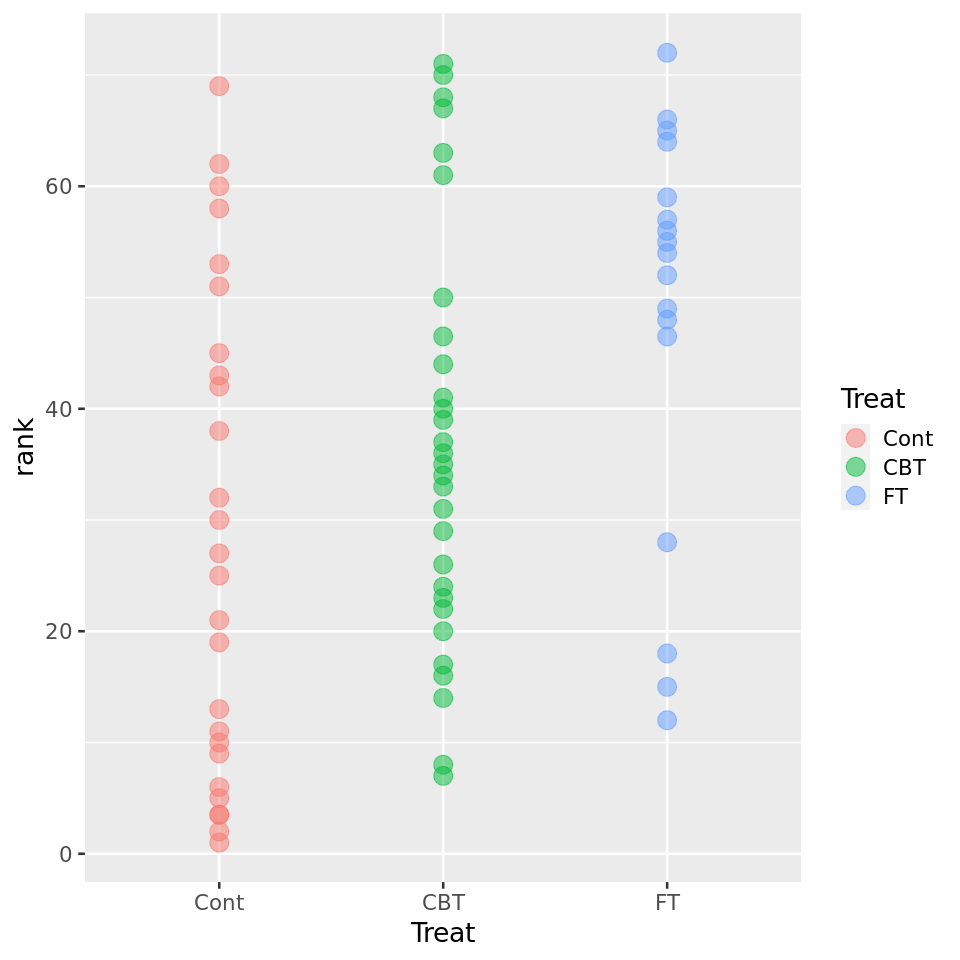

In [41]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data_rank %>% 
ggplot(aes(x=Treat, y=rank, color=Treat)) + 
  geom_point(size=5, alpha=0.5) +
  theme_gray(base_size=16)  

The effect size for rank difference is defined by $\epsilon_R^2$

$$
\epsilon_{R}^{2}=\frac{H}{\left(n^{2}-1\right) /(n+1)}
$$

$$
\begin{align}
\text{where }H &= \text{H-statistic}\\
n &= \text{number of samples}
\end{align}
$$

In [42]:
h <- data %>% 
     rstatix::kruskal_test(Weight ~ Treat) %>% 
     pull(statistic) %>% as.numeric

n <- nrow(data)

epsilon_squared <- h/((n^2-1)/(n+1))

tibble(h = h,
       n = n,
       epsilon_squared = epsilon_squared)

h,n,epsilon_squared
<dbl>,<int>,<dbl>
9.047499,72,0.1274296


**Using a function**

We can also calculate the effect size using the `rank_epsilon_squared` function from the `rstatix` library
- `x` = dependent variable (Weight)
- `y` = independent variable (Treat)

In [43]:
effectsize::rank_epsilon_squared(x=data$Weight, 
                                 g=data$Treat)

rank_epsilon_squared,CI,CI_low,CI_high
<dbl>,<dbl>,<dbl>,<dbl>
0.1274296,0.95,0.03458024,1


To interpret $\epsilon^2$, we can use the `interpret_epsilon_squared` function from the `rstatix` library

In [44]:
effectsize::rank_epsilon_squared(x=data$Weight, g=data$Treat) %>%
pull(rank_epsilon_squared) %>%
effectsize::interpret_epsilon_squared()

[1] "medium"
(Rules: field2013)


---
# Application: Statistical plotting

We will use the `ggstatsplot` library. For details see: https://indrajeetpatil.github.io/ggstatsplot/

In [ ]:
library(ggstatsplot)

In [ ]:
library(tidyverse)

data <- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/anorexia.csv")

data <- data %>% 
        mutate(Weight = Postwt - Prewt,
               Treat = as.factor(Treat)) %>%
        mutate(Treat = fct_relevel(Treat, "Cont","CBT","FT")) %>%
        select(Treat, Weight)

head(data %>% filter(Treat=="Cont"))
head(data %>% filter(Treat=="CBT"))
head(data %>% filter(Treat=="FT"))

## 1. Parametric plot (1-way ANOVA)

We will make a plot comparing the >2 independent groups with parametric 1-way ANOVA using the `ggbetweenstats` function from `ggstatsplot`
- `x`: grouping variable
- `y`: measure variable
- `type`: default is `parametric`
- `pairwise.comparisons`: default is `TRUE` to show pairwise tests
- `plot.type`: set to `box` to omit violin plot (default is `boxviolin`)

For details, see: https://indrajeetpatil.github.io/ggstatsplot/reference/ggbetweenstats.html

In [ ]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=10)

data %>% 
ggbetweenstats(x = Treat,
               y = Weight,
               plot.type = "box") +
  theme_classic(base_size=16)  

## 2. Non-parametric plot (Kruskal-Wallis)

We will make a plot comparing the >2 independent groups with non-parametric Kruskal Wallis test using the `ggbetweenstats` function from `ggstatsplot`
- `x`: grouping variable
- `y`: measure variable
- `type`: set to `non-parametric`
- `pairwise.comparisons`: default is `TRUE` to show pairwise tests
- `plot.type`: set to `box` to omit violin plot (default is `boxviolin`)

For details, see: https://indrajeetpatil.github.io/ggstatsplot/reference/ggbetweenstats.html

In [ ]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=10)

data %>% 
ggbetweenstats(x = Treat,
               y = Weight,
               type = "non-parametric",
               plot.type = "box") +
  theme_classic(base_size=16)

---
## Exercise - Comparing measures >2 independent groups

For this exercise, we will use the Framingham heart dataset

In [ ]:
library(tidyverse)

# load data
data_plot <- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/framingham.csv")

# recap of what was done
data_plot <- data_plot %>% 
             rename(sex = male) %>%
             mutate(sex = as.factor(sex),
                    age = as.integer(age),
                    education = as.factor(education),
                    currentSmoker = as.factor(currentSmoker),
                    cigsPerDay = as.integer(cigsPerDay),
                    BPMeds = as.factor(BPMeds),
                    prevalentStroke = as.factor(prevalentStroke),
                    prevalentHyp = as.factor(prevalentHyp),
                    diabetes = as.factor(diabetes),
                    totChol = as.integer(totChol),
                    heartRate = as.integer(heartRate),
                    TenYearCHD = as.factor(TenYearCHD)
                    )

data_plot <- data_plot %>% 
             mutate(glucose = round(glucose/18, digits=1)) %>% # mg/dL to mmol/L
             mutate(totChol = round(totChol/39, digits=1))     # mg/dL to mmol/L

head(data_plot)

### Part 1

Plot the distribution of systolic BP (`sysBP`) in patients with different education backgrounds (`education`) using `ggplot` from `tidyverse`. You may use `facet_grid` to split the plots for the different categories

In [ ]:
library(tidyverse)

# start here

In [ ]:
# solution

# set plot dimensions
options(repr.plot.width=10, repr.plot.height=10)

data_plot %>% 
ggplot(aes(x=sysBP, fill=education)) +
  geom_histogram(binwidth=2) + 
  facet_grid(education ~., scales="free") +
  theme_grey(base_size=16)

### Part 2

Generate a statistical plot comparing the systolic BP `(sysBP)` of patients with different education backgrounds `(education)` using `ggbetweenstats` from `ggstatsplot`
- Explain your choice of test
- State the summary statistic (mean or median) of each group
- State the effect size, 95% CI and p-value

In [ ]:
library(ggstatsplot)

# start here

In [ ]:
# solution

# set plot dimensions
options(repr.plot.width=10, repr.plot.height=10)

data_plot %>% 
ggbetweenstats(x = education,
               y = sysBP,
               plot.type = "box") +
  theme_classic(base_size=16)  